In [4]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [5]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [6]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,100000)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [7]:
R0, kappa = 2.5, 1e4
N = 1e7
xi = 50
ds = xi*np.logspace(-1,1,3)

ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
x,y = S/N, I/N
z = 1-x-y
tp = ts[np.argmax(y)]
dt = ts[1]-ts[0]

fit_d = lambda x,y,z, d_over_xi: R0/(1+y*kappa) * ( x + (1- np.exp(-d_over_xi))*z )-1
sel_d = lambda x,y,z,d_over_xi: fit_d(x,y,z,d_over_xi) - fit_d(x,y,z,0)


simple_sel = lambda z, d_over_xi: (1-np.exp(-d_over_xi))*z#/(1-z)

p_surv = lambda x,y,z, d_over_xi: get_p_surv_inv_int(fit_d(x,y,z,d_over_xi=d_over_xi), dt=dt,reg= 1e-1)

def plot_f_s_pi(ax, x,y,z, ts, ds, xi, legend_fontsize=20, tqdm_disabled=False):
    tp = ts[np.argmax(y)]

    for d in tqdm(ds,disable=tqdm_disabled):
        fit = fit_d(x,y,z,d/xi)
        sel = sel_d(x,y,z,d/xi)

        line_d, = ax.plot(ts,fit, label = fr'$\frac{{d}}{{\xi}}={d/xi:.2f}$',alpha=.5)

        line_sel, = ax.plot(ts,sel,  color = line_d.get_color(), linestyle='--')#,label = f'sel d={d}',)

        ax.plot(ts,p_surv(x,y,z,d/xi),  color = line_d.get_color(), linestyle=':')#,label = f'p_surv d={d}',)
        ax.plot(ts,sel/(1+sel),  color = line_d.get_color(), linestyle='-.')#,label = f'p_surv d={d}',)
    
    handles= ax.get_legend_handles_labels()[0]
    handles = handles +[
        Line2D([0], [0], color='k', lw=2, label='fit'),
        Line2D([0], [0], color='k', lw=2, linestyle='--', label='selection'),
        Line2D([0], [0], color='k', lw=2, linestyle=':', label=r'$\pi_d(t)$ (inhomogeneous branching)'),
    ]

    # ax.legend(handles=handles,loc='best', fontsize=legend_fontsize)
    ax.axvline(tp, color='k', linestyle='--')

    ax.set_xscale('log')
    ax.set_yscale('log')

def plot_y_psurv(ax, x,y,z, ts, ds, xi, legend_fontsize=20, tqdm_disabled=False):
    tp = ts[np.argmax(y)]
    for d in tqdm(ds,disable=tqdm_disabled):
            fit = fit_d(x,y,z,d/xi)
            sel = sel_d(x,y,z,d/xi)

            line_y_psurv, = ax.plot(ts,y * p_surv(x,y,z,d/xi), linestyle=':')#,label = f'p_surv d={d}',)
            ax.plot(ts,y * sel/(1+sel),  color = line_y_psurv.get_color(), linestyle='-.')#,label = f'p_surv d={d}',)
            ax.plot(ts,y * sel,  color = line_y_psurv.get_color(), linestyle='--',alpha=.5)#,label = f'p_surv d={d}',)

    handles= []

    handles = handles +[
    Line2D([0], [0], color='k', lw=2, linestyle=':', label=r'$y(t) \pi_d(t)$ (inhomogeneous branching)'),
    Line2D([0], [0], color='k', lw=2, linestyle='-.', label=r'$y(t) \frac{s_d(t)}{1 + s_d(t)}$ (adiabatic)'),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$y(t) s_d(t)$'),
]
    ax.axvline(tp, color='k', linestyle='--')
    # ax.legend(handles=handles,loc='best', fontsize=legend_fontsize)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-8,1e-4)

def plot_integral_y_psurv(ax, x,y,z, ts, ds, xi, legend_fontsize=20, tqdm_disabled=False, logscales =False, return_fits = False):
    tp = ts[np.argmax(y)]
    dt = ts[1]-ts[0]
    list_fits = []
    for d in tqdm(ds,disable=tqdm_disabled):
            fit = fit_d(x,y,z,d/xi)
            sel = sel_d(x,y,z,d/xi)
            cum_y_p_surv = np.cumsum(y * p_surv(x,y,z,d/xi))*dt
            #fit cum_y_p_surv with quadratic
            line_y_psurv, = ax.plot(ts[cum_y_p_surv<np.max(cum_y_p_surv)], cum_y_p_surv[cum_y_p_surv<np.max(cum_y_p_surv)], linestyle='-',alpha=.5)#,label = f'p_surv d={d}',

            p = np.polyfit(ts[cum_y_p_surv<np.max(cum_y_p_surv)*.75], cum_y_p_surv[cum_y_p_surv<np.max(cum_y_p_surv)*.75], 2)
            list_fits.append(p)

            ax.plot(ts, np.polyval(p,ts), linestyle=':', color = line_y_psurv.get_color(), alpha=.5)
            
            ax.plot(ts,np.cumsum(y * sel/(1+sel)*dt),  color = line_y_psurv.get_color(), linestyle='-.', alpha=.5)#,label = f'p_surv d={d}',)

            sim_sel = simple_sel(z,d/xi)
            sim_pi = sim_sel/(1+sim_sel)
            ax.plot(ts,np.cumsum(y * sim_sel*dt),  color = line_y_psurv.get_color(), linestyle='-.', alpha=.5,marker='x', markevery=1000)#,label = f'p_surv d={d}',)

            # ax.plot(ts,np.cumsum(y * sel*dt),  color = line_y_psurv.get_color(), linestyle='--',alpha=.5)#,label = f'p_surv d={d}',)

    # ax.plot(ts, ts/(6*N), color='k', linestyle='--')
    ax.plot(ts, ts**2/(500*N), color='k', linestyle=':')

    # ax.annotate(r'$\sim t$', (ts[len(ts)//10], ts[len(ts)//10]*(1.5)/(4*N)), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)
    ax.annotate(r'$\sim t^2$', (ts[len(ts)//10], ts[len(ts)//10]**2*(1.5)/(4*N)), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)

    handles= []

    handles = handles +[
    Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$\int_0^t y(t) \pi_d(t) dt$ (inhomogeneous branching)'),
    Line2D([0], [0], color='k', lw=2, linestyle='-.', label=r'$\int_0^t y(t) \frac{s_d(t)}{1 + s_d(t)} dt$ (adiabatic)'),
    Line2D([0], [0], color='k', lw=2, linestyle=':', label='quadratic fit'),
    # Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$\int_0^t y(t) s_d(t) dt$'),

]
    ax.axvline(tp, color='k', linestyle='--')
    ax.legend(handles=handles,loc=(1.01,.1), fontsize=legend_fontsize)

    if logscales:
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.set_ylim(bottom= 0,top=.35)
        ax.set_xlim(left=ts[1], right=5*kappa/R0)
    if return_fits:
        return np.array(list_fits)

100%|██████████| 3/3 [00:00<00:00, 133.20it/s]


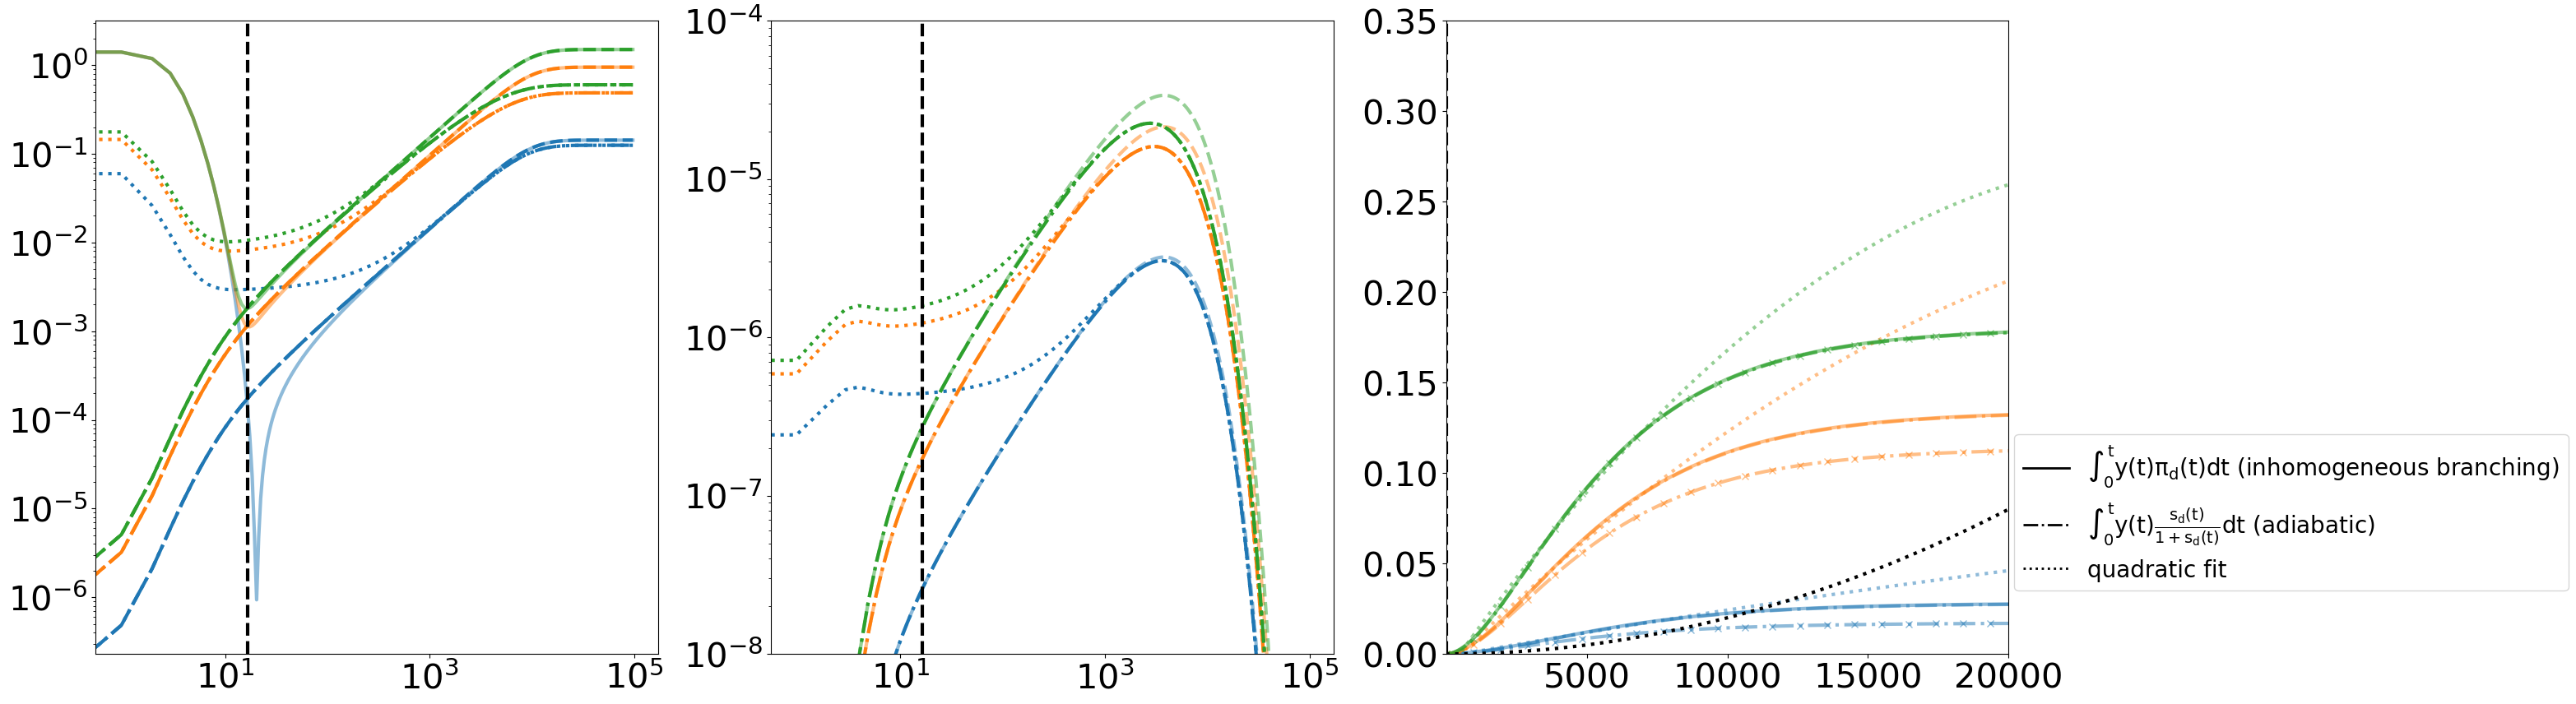

In [8]:

fig,ax = plt.subplots(1,3,figsize=(30,10))

plot_f_s_pi(ax[0], x,y,z, ts, ds, xi)
plot_y_psurv(ax[1], x,y,z, ts, ds, xi, legend_fontsize=20)
plot_integral_y_psurv(ax[2], x,y,z, ts, ds, xi, legend_fontsize=20,logscales=False)
# ax[2].set_xscale('log')



100%|██████████| 3/3 [00:00<00:00, 119.90it/s]


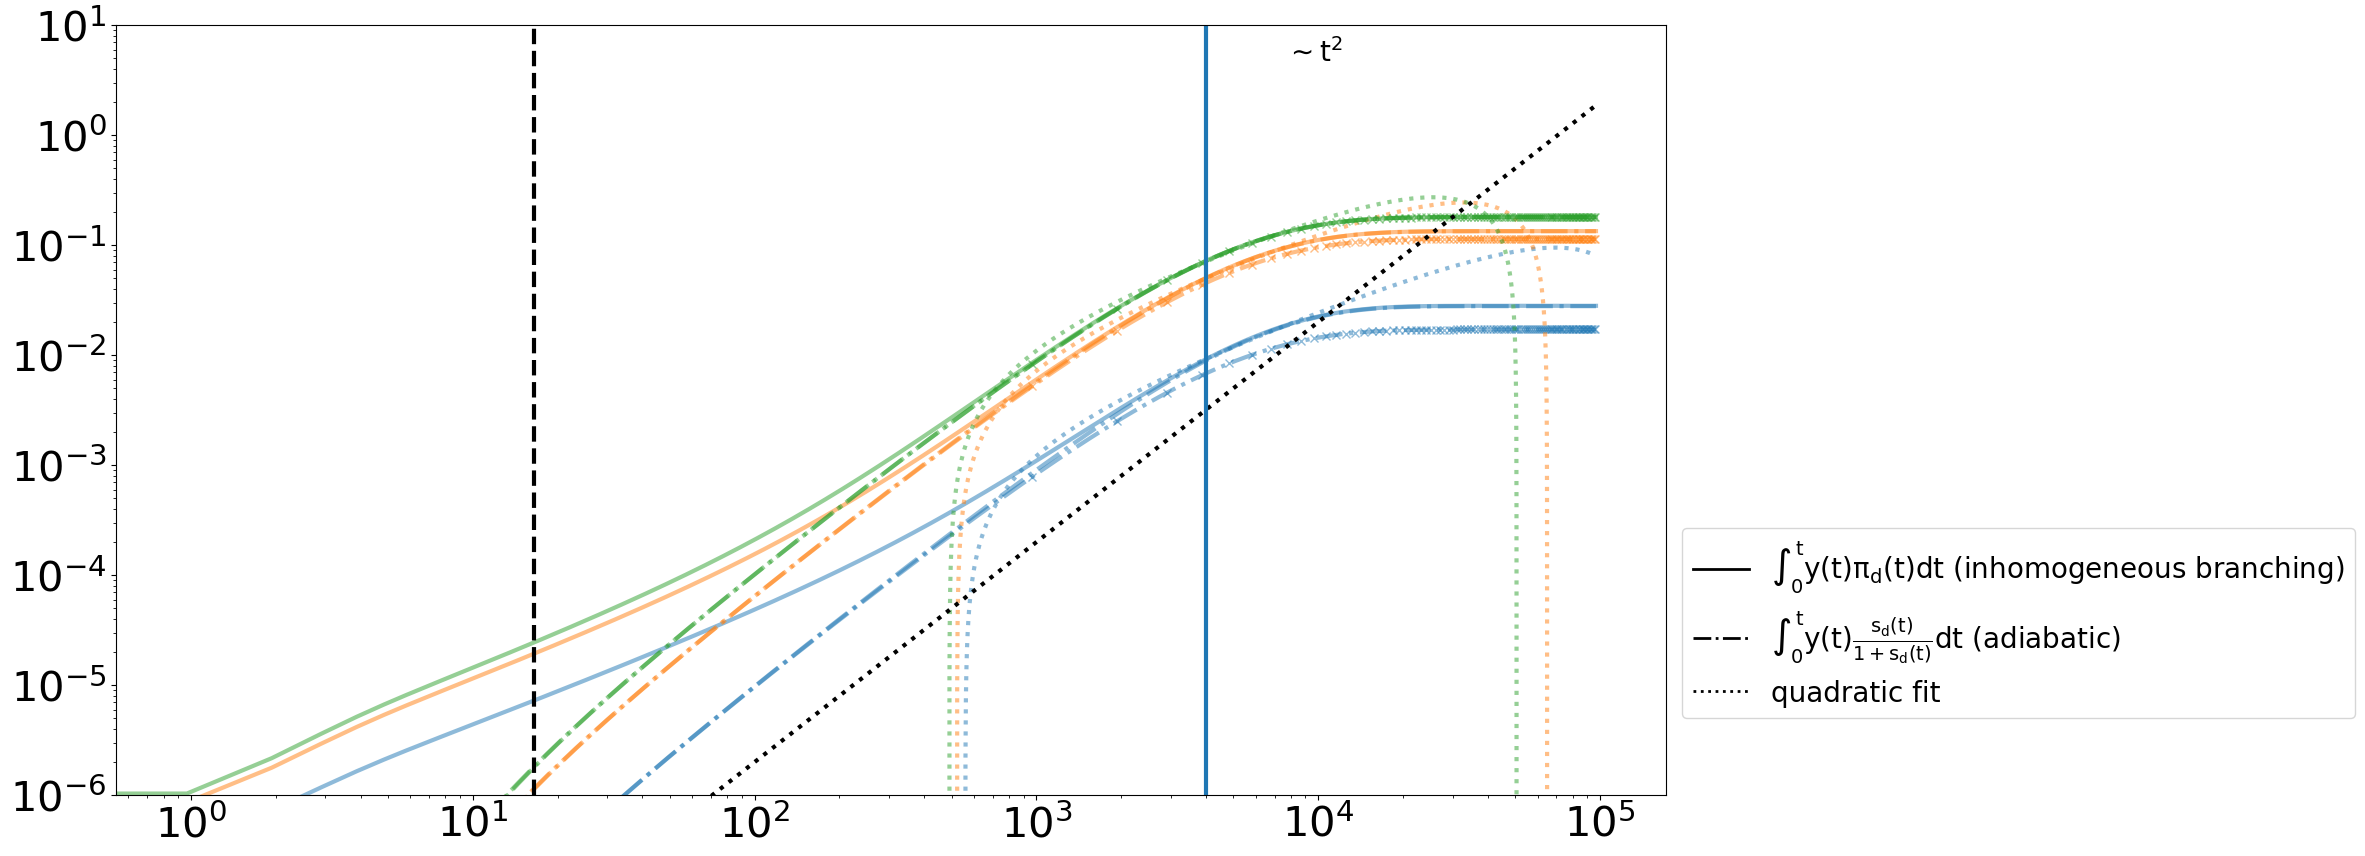

In [9]:
fig,ax = plt.subplots(1,1,figsize=(20,10))

quad_fits = plot_integral_y_psurv(ax, x,y,z, ts, ds, xi, legend_fontsize=20,logscales=True, return_fits=True)
# zp = lambda R0,kappa: R0/kappa * (np.log((R0-1)*kappa**2 /(R0**2))- (R0-1)/R0)
zp = lambda R0,kappa: 0
yp = lambda R0,kappa: (R0-1)/kappa
zinf= lambda R0,kappa: 1- 1/R0 + 1/kappa
c_d= lambda d_over_xi: np.exp(-d_over_xi)
# for Matplotlib version >= 1.5
plt.gca().set_prop_cycle(None)
quadratic_approx = lambda t, d_over_xi, R0, kappa: (1-c_d(d_over_xi))*(R0-1)/(2*kappa)*t *(zinf(R0,kappa)*R0/kappa *t - 2*zp(R0,kappa)*(R0/kappa *t-1) )

#second quadratic approximation: -0.5*(t**2*yp*(-1 + c(d))*(R0*(zinf - zp*(2 + zp)) + R0*zp**2*c(d)))/(\[Kappa]*(1 + zp - zp*c(d))**2) - (t*yp*(-1 + c(d))*(2*zp*(1 + zp)*\[Kappa] - 2*zp**2*\[Kappa]*c(d)))/(2.*\[Kappa]*(1 + zp - zp*c(d))**2)
# c(d) = c_d(d_over_xi)
second_quadratic_approx = lambda t, d_over_xi, R0, kappa: -0.5*(t**2*yp(R0,kappa)*(-1 + c_d(d_over_xi))*(R0*(zinf(R0,kappa) - zp(R0,kappa)*(2 + zp(R0,kappa))) + R0*zp(R0,kappa)**2*c_d(d_over_xi)))/(kappa*(1 + zp(R0,kappa) - zp(R0,kappa)*c_d(d_over_xi))**2) - (t*yp(R0,kappa)*(-1 + c_d(d_over_xi))*(2*zp(R0,kappa)*(1 + zp(R0,kappa))*kappa - 2*zp(R0,kappa)**2*kappa*c_d(d_over_xi)))/(2.*kappa*(1 + zp(R0,kappa) - zp(R0,kappa)*c_d(d_over_xi))**2)

#quadratic around kappa/R0: (yp*zinf*\[Kappa]*(-((5 + (-5 + E)*E)*R0**2) + 2*(3 - 2*E)*R0*t*\[Kappa] + (-2 + E)*t**2*\[Kappa]**2)*(-1 + c(d)))/(2.*E**2*R0**3)
#E-> np.e
quadratic_around_kappa_ov_R0 = lambda t, d_over_xi, R0, kappa: (yp(R0,kappa)*zinf(R0,kappa)*kappa*(-((5 + (-5 + np.e)*np.e)*R0**2) + 2*(3 - 2*np.e)*R0*t*kappa + (-2 + np.e)*t**2*kappa**2)*(-1 + c_d(d_over_xi)))/(2.*np.e**2*R0**3)

for d in ds:
    # ld,= ax.plot(ts, quadratic_approx(ts,d/xi, R0, kappa), linestyle='', alpha=1,marker='x', markevery=100)
    # ax.plot(ts, second_quadratic_approx(ts,d/xi, R0, kappa), linestyle='', alpha=1,marker='o', markevery=120,color=ld.get_color())
    ax.plot(ts, quadratic_around_kappa_ov_R0(ts,d/xi, R0, kappa), linestyle='', alpha=1,marker='s', markevery=1200)#,color=ld.get_color())

ax.set_ylim(1e-6,1e1)
ax.axvline(kappa/R0)

For d/xi=1e-01 the quadratic fit is -2.00e-11 t^2 + 2.78e-06 t + -1.55e-03
For d/xi=1e+00 the quadratic fit is -2.36e-10 t^2 + 1.54e-05 t + -8.00e-03
For d/xi=1e+01 the quadratic fit is -4.35e-10 t^2 + 2.22e-05 t + -1.08e-02


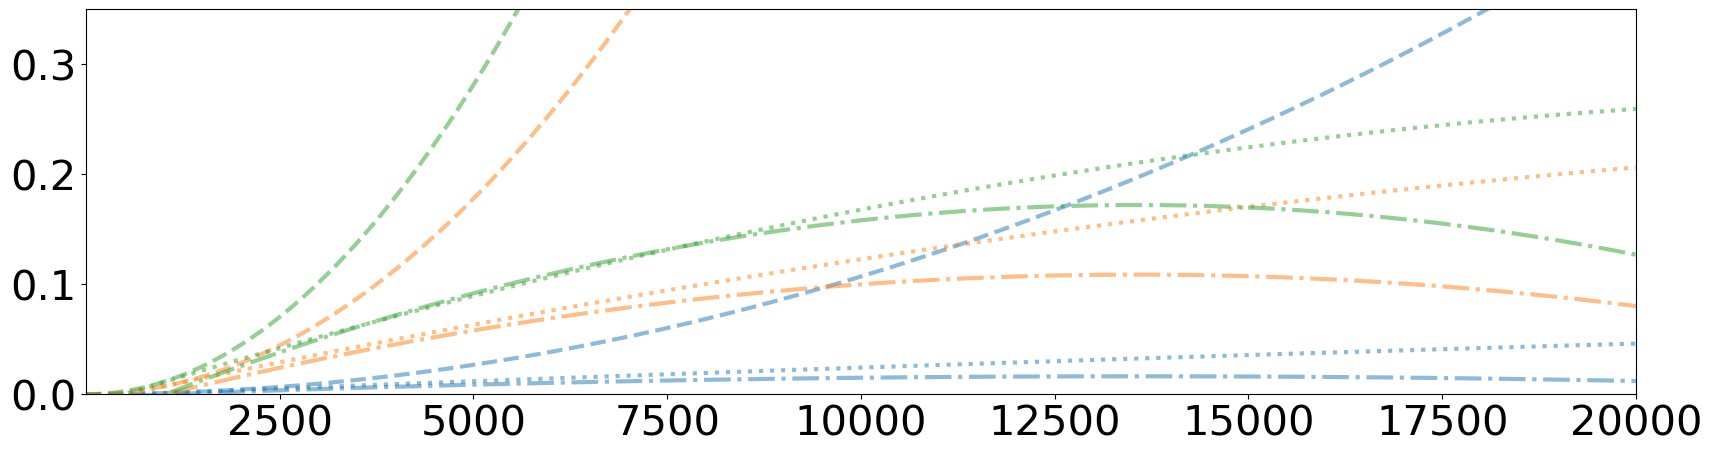

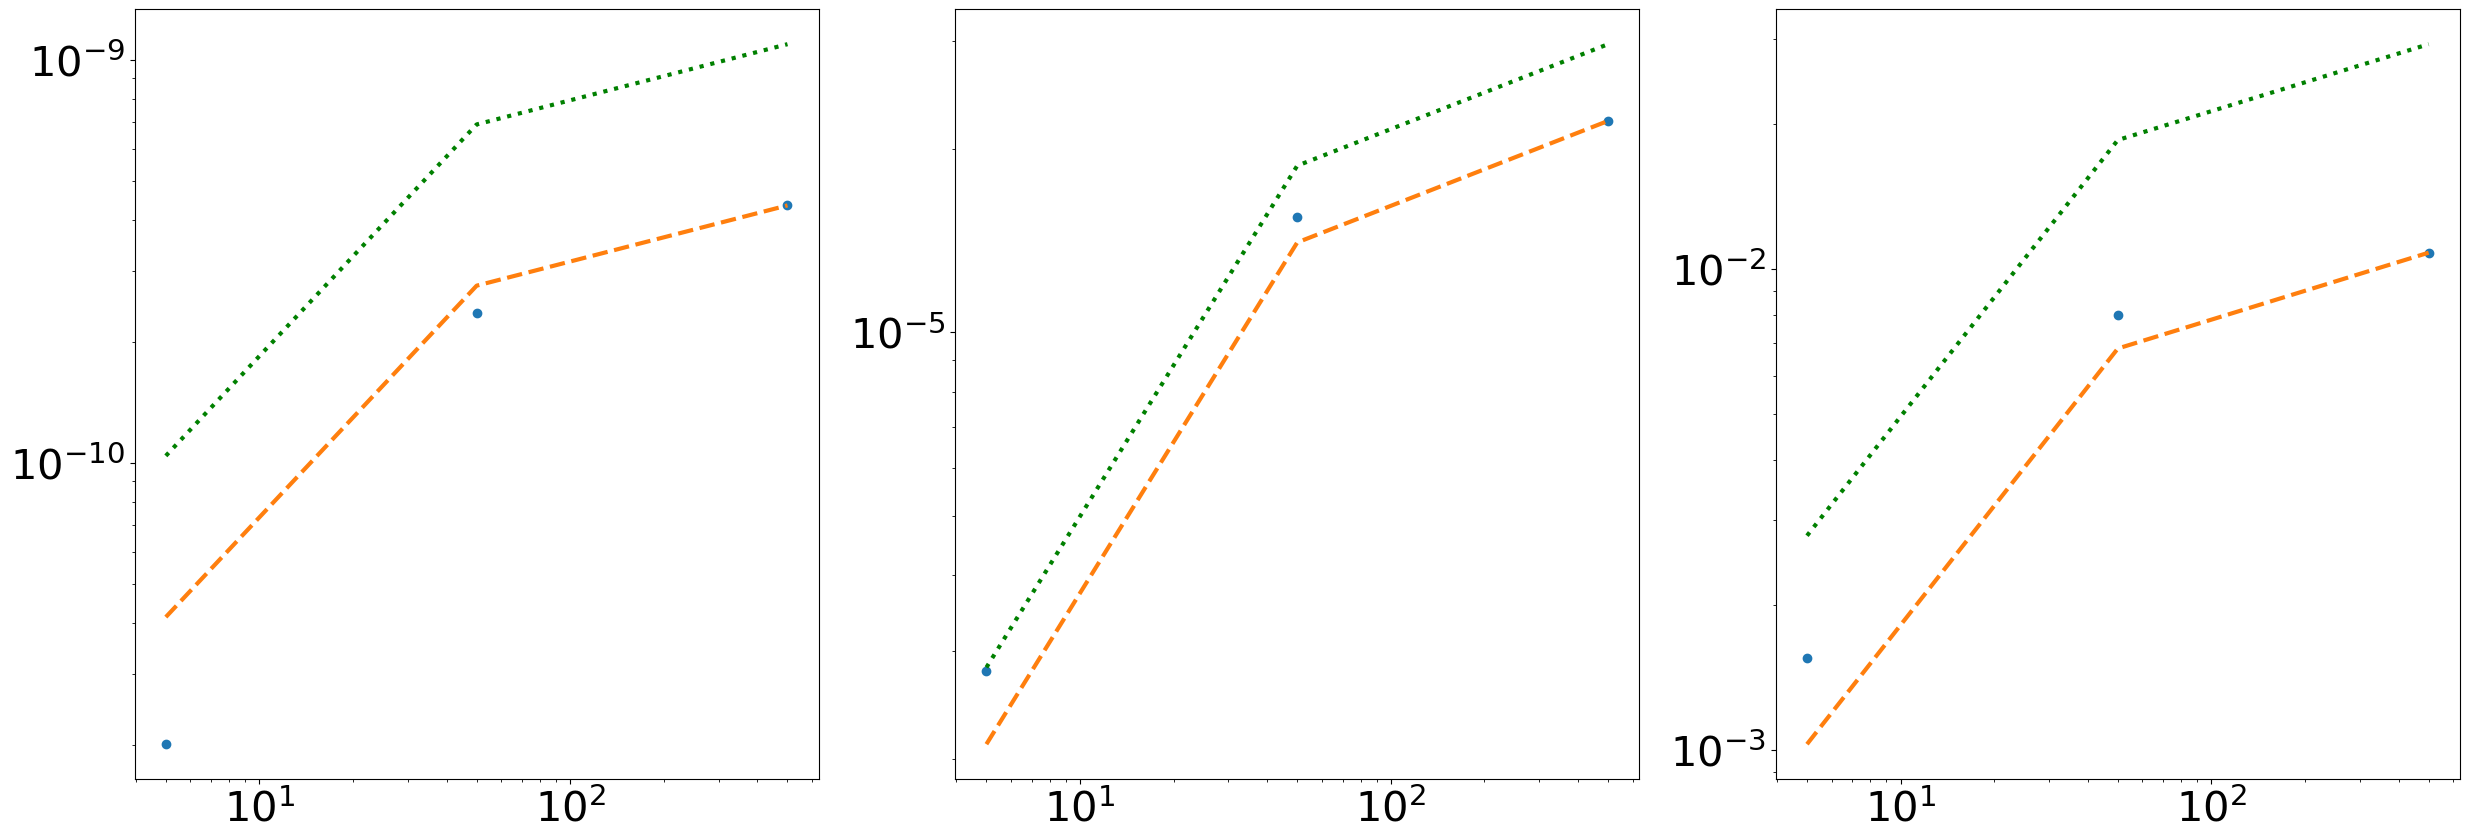

In [10]:
#coeff list: {
# (1 - c[d]) (yp ((5 + (-5 + E) E) zinf + (-5 + E^2) zp) \[Kappa] )/(2 E^2 R0), 
#(1 - c[d]) (yp ((-3 + 2 E) zinf + 3 zp) )/E^2,
# (1 - c[d]) (-R0 yp ((-2 + E) zinf + 2 zp) )/(2 E^2 \[Kappa])}

quad_comparison_0 = (1-c_d(ds/xi)) * (yp(R0,kappa) * ((5 + (-5 + np.e) * np.e) * zinf(R0,kappa) + (-5 + np.e**2) * zp(R0,kappa)) * kappa)/(2 * np.e**2 * R0)
quad_comparison_1 = (1-c_d(ds/xi)) * (yp(R0,kappa) * ((-3 + 2 * np.e) * zinf(R0,kappa) + 3 * zp(R0,kappa)) )/np.e**2
quad_comparison_2 = (1-c_d(ds/xi)) * (-R0 * yp(R0,kappa) * ((-2 + np.e) * zinf(R0,kappa) + 2 * zp(R0,kappa)) )/(2 * np.e**2 * kappa)

quad_comparison_arr = np.array([quad_comparison_0,quad_comparison_1,quad_comparison_2]).T
quad_comparison_arr = quad_comparison_arr[:,::-1]

#second list = {{0,
# -yp zp (-1 + c[d]),
# -((yp (R0 zinf - 2 R0 zp) (-1 + c[d]))/( 2 \[Kappa]))}

second_quad_comparison_0 = np.zeros_like(ds)
second_quad_comparison_1 = -yp(R0,kappa) * zp(R0,kappa) * (-1 + c_d(ds/xi))
second_quad_comparison_2 = -((yp(R0,kappa) * (R0 * zinf(R0,kappa) - 2 * R0 * zp(R0,kappa)) * (-1 + c_d(ds/xi)))/(2 * kappa))

second_quad_comparison_arr = np.array([second_quad_comparison_0,second_quad_comparison_1,second_quad_comparison_2]).T
second_quad_comparison_arr = second_quad_comparison_arr[:,::-1]



fig,ax= plt.subplots(1,1,figsize=(20,5))
#repot fits
for id, d in enumerate(ds):
    p = quad_fits[id]
    print(f'For d/xi={d/xi:.0e} the quadratic fit is {p[0]:.2e} t^2 + {p[1]:.2e} t + {p[2]:.2e}')
    lp,=ax.plot(ts, np.polyval(p,ts), linestyle=':', alpha=.5)
    ax.plot(ts, np.polyval(quad_comparison_arr[id],ts), linestyle='-.', alpha=.5, color=lp.get_color())
    ax.plot(ts, np.polyval(second_quad_comparison_arr[id],ts), linestyle='--', alpha=.5, color=lp.get_color())


ax.set_xlim(left=ts[1], right=5*kappa/R0)
ax.set_ylim(bottom= 0,top=.35)

#quadratic (1-c(d)) (yp zinf  )/(2 (E^2) R0 ) ((5 + (-5 + E) E) \[Kappa] - 2 (3 - 2 E) R0 t - (-2 + E) (R0^2 t^2)/\[Kappa])

fig,ax= plt.subplots(1,3,figsize=(30,10))


for ie in range(3):
    ax[ie].plot(ds, np.abs(quad_fits[:,ie]), linestyle='', marker='o')

    ax[ie].set_xscale('log')
    ax[ie].set_yscale('log')
    

    a0 = np.abs(quad_fits[:,ie]/(1-c_d(ds/xi)))[-1]
    ax[ie].plot(ds, (1-c_d(ds/xi))*a0, linestyle='--')

    ax[ie].plot(ds, np.abs(quad_comparison_arr[:,ie]), linestyle=':', color='green')
    # ax[ie].plot(ds, np.abs(second_quad_comparison_arr[:,ie]), linestyle='-.', color='red')




In [11]:
quad_comparison_arr

array([[-1.04087129e-10,  2.82468420e-06, -2.78775204e-03],
       [-6.91402157e-10,  1.87630571e-05, -1.85177339e-02],
       [-1.09373245e-09,  2.96813716e-05, -2.92932938e-02]])

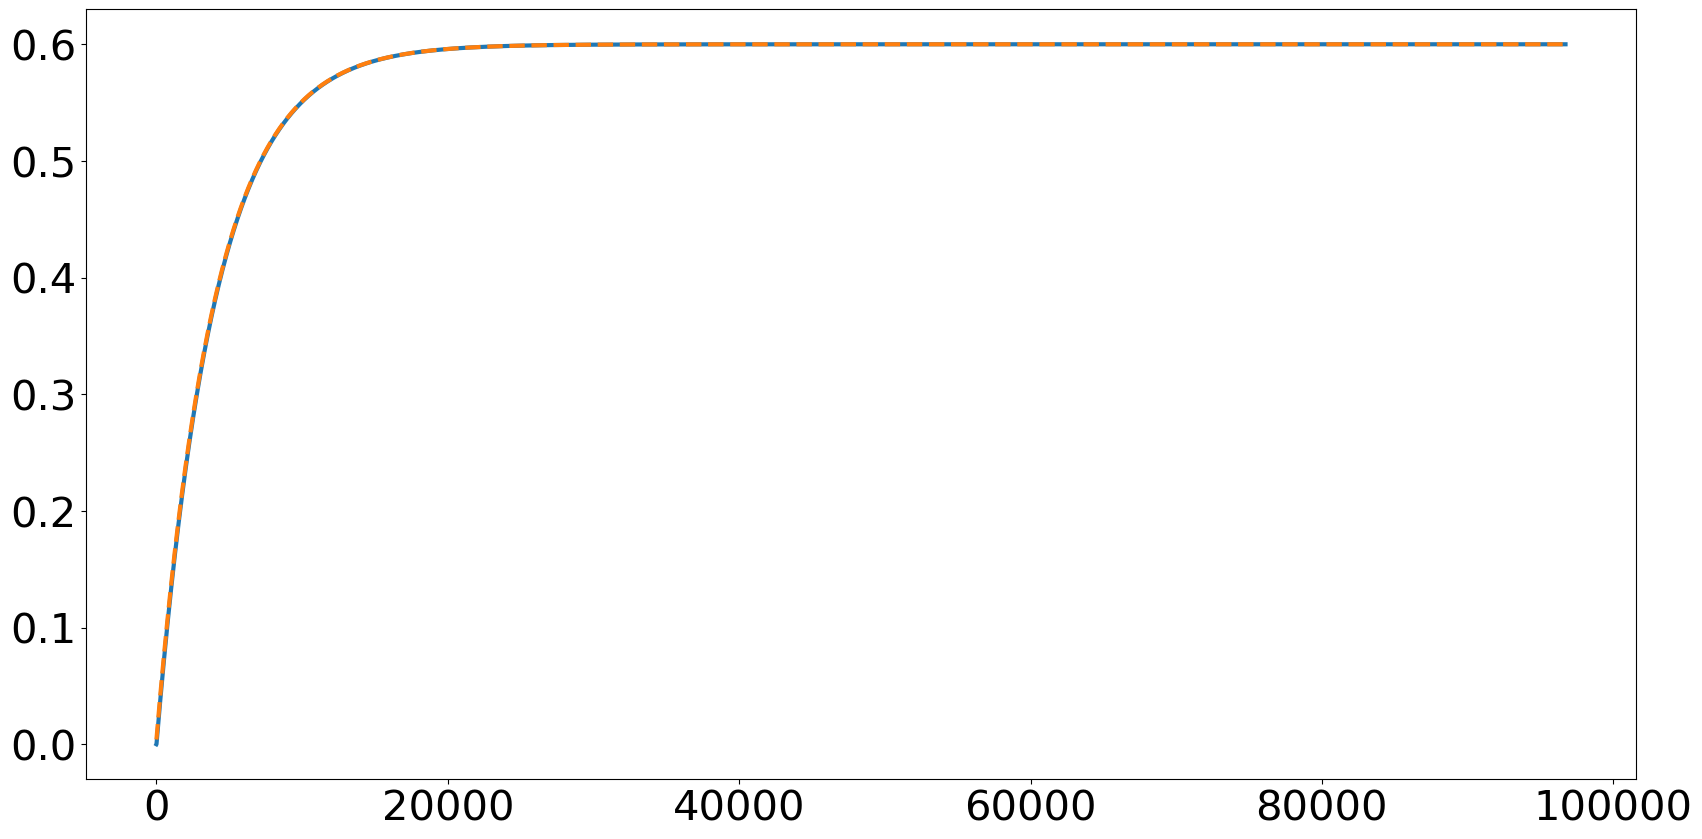

In [12]:
zp = lambda R0,kappa: R0/kappa * (np.log((R0-1)*kappa**2 /(R0**2))- (R0-1)/R0)

fig,ax= plt.subplots(1,1,figsize=(20,10))
ax.plot(ts,z)
ax.plot(ts, zinf(R0,kappa) + (zp(R0,kappa)-zinf(R0,kappa))*np.exp(-ts*R0/kappa),linestyle='--')
# ax.plot(ts, zinf(R0,kappa)*(1-np.exp(-ts*R0/kappa)),linestyle=':')